In [1]:
from google.colab import files
uploaded = files.upload()

Saving data_modelling.py to data_modelling.py
Saving preprocessor2.py to preprocessor2.py


In [23]:
from preprocessor2 import Preprocessor2
import pandas as pd
from sklearn.metrics import accuracy_score
from data_modelling import DataModelling
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import numpy as np

In [24]:
file_path = "/content/drive/MyDrive/Applied Machine Learning/data/steam_data_with_correct_prices.csv"
preprocessor = Preprocessor2(file_path)
game_types_count_value = 5000      #3500
supported_tags_count_value = 5000  #4000
common_languages_count_value = 5000 #3500
drop_reviews = True
cleaned_df = preprocessor.run_preprocessor(game_types_count_value,supported_tags_count_value,common_languages_count_value,drop_reviews)

seasons sorunsuz bir şekilde eklendi.


In [25]:
# RandomForest uygulayacağımız için NaN'ları dropladık.
cleaned_df = cleaned_df.dropna()

In [26]:
df = cleaned_df
number_of_target = 9 # it should be 3,5 or 9
apply_data_augmentation_bool = True
data_modelling = DataModelling(df,number_of_target,apply_data_augmentation_bool)

In [27]:
model_df = data_modelling.run_modelling()

In [28]:
# sample = cleaned_df.sample(frac=1)
X = model_df.drop("review_text", axis = 1)
y = model_df["review_text"]
from sklearn.model_selection import train_test_split

# Veriyi train ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.ensemble import RandomForestClassifier
# Modeli başlatma
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Modeli eğitim verileri ile eğitme
rf.fit(X_train, y_train)

# Test veri seti üzerinde tahmin yapma
y_pred = rf.predict(X_test)

# Model performansını değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7436132502139102


**Hyperparameter Optimization**

In [42]:
y_pred_list = list(y_pred)
y_test_list = list(y_test)

In [43]:
def get_counts(temp_list):
    from collections import defaultdict

    unique_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    count_dict = defaultdict(int)
    for eleman in unique_list:
        count_dict[eleman] = temp_list.count(eleman)
    return count_dict

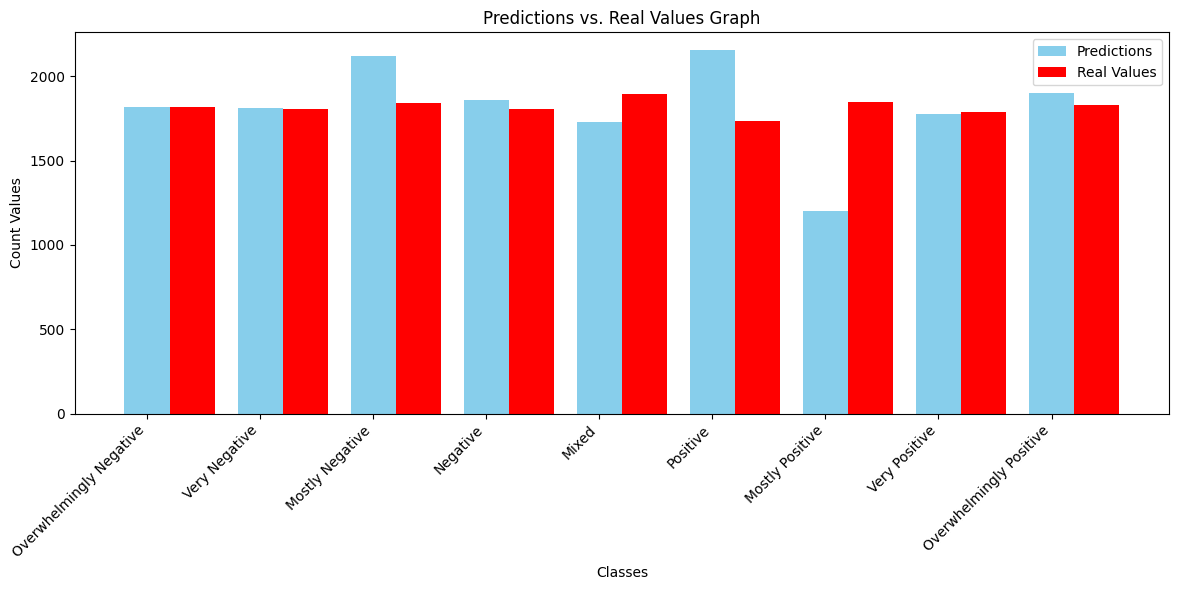

In [88]:
counter_y_pred_list = get_counts(y_pred_list)
counter_y_test_list = get_counts(y_test_list)

mapping = {8: 'Overwhelmingly Positive', 7: 'Very Positive', 6: 'Mostly Positive', 5: 'Positive', 4: 'Mixed', 3: 'Negative', 2: 'Mostly Negative', 1: 'Very Negative', 0: 'Overwhelmingly Negative'}
counter_y_pred_list = {mapping[key]: value for key, value in counter_y_pred_list.items()}
# counter_y_test_list ={mapping[key]: value for key, value in counter_y_test_list.items()}

keys_pred = counter_y_pred_list.keys()
values_pred = counter_y_pred_list.values()

keys_test = counter_y_test_list.keys()
values_test = counter_y_test_list.values()

import matplotlib.pyplot as plt
# Grafik çizme
plt.figure(figsize=(12, 6))  # Grafik boyutunu genişletmek için

# Genel çubuk genişliği
width = 0.4

# Tahmin edilen değerlerin çubuklarını çizme
plt.bar(keys_pred, values_pred, width=width, color='skyblue', label='Predictions')

# Gerçek değerlerin çubuklarını çizme
# Genel çubuk genişliğini dikkate alarak bir miktar sağa kaydırma
plt.bar([key + width for key in keys_test], values_test, width=width, color='red', label='Real Values')

# Eksen etiketleri ve başlık
plt.xlabel('Classes')
plt.ylabel('Count Values')
plt.title('Predictions vs. Real Values Graph')
# plt.xticks([key + width/2 for key in keys_pred], keys_pred, rotation=45, ha='right')  # X eksenindeki etiketleri güncelleme
plt.xticks(rotation=45, ha='right')

# Grafik gösterme
plt.legend()
plt.tight_layout()  # Grafik öğelerini sıkılaştırma
plt.show()


In [9]:
# RandomForestClassifier modelini oluşturma
rf_model = RandomForestClassifier(random_state=42)

# GridSearchCV için parametre aralığını belirleme
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

# GridSearchCV'yi oluşturma
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Modeli eğitim verisi ile eğitme
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve sonuçları görüntüleme
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi CV skoru:", grid_search.best_score_)

# En iyi model ile test verisi üzerinde tahmin yapma
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Test verisi üzerindeki doğruluk skorunu görüntüleme
accuracy = accuracy_score(y_test, y_pred)
print("Test verisi üzerindeki doğruluk skoru:", accuracy)


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


En iyi parametreler: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
En iyi CV skoru: 0.7315273193986065
Test verisi üzerindeki doğruluk skoru: 0.7475858696980809
